# Ablation study on the Infinite deck environment

In [1]:
import gym
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from src.utils.general import state_to_index
from src.agents import Agent

def play_episode(env: gym.Env, agent: Agent) -> float:
    """plays one episode of given agent"""
    state = env.reset()
    state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [3]:
def gaussian_smoothing(x: np.ndarray, window: int = 100000) -> np.ndarray:
    """smooth the curve using gaussian smoothing"""
    kernel = np.exp(-np.linspace(-1, 1, window)**2)
    kernel /= kernel.sum()
    return np.convolve(x, kernel, mode='valid')

import torch
from torchaudio.functional import convolve as torch_convolve

def gaussian_smoothing_gpu(x: np.ndarray, window: int = 10_000) -> np.ndarray:
    """smooth the curve using gaussian smoothing"""
    x = torch.from_numpy(x).cuda()
    kernel = torch.exp(-torch.linspace(-1, 1, window)**2).cuda()
    kernel /= kernel.sum()
    x = x.float()
    kernel = kernel.float()
    return torch_convolve(x, kernel, mode='valid').cpu().numpy()

def plot_training_rewards(rewards: np.ndarray):
    """plot the training rewards"""
    running_average = gaussian_smoothing_gpu(rewards)
    plt.plot(running_average)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Running average reward")
    plt.show()

In [4]:
from src.envs import SimpleBlackjack

## Sarsa

In [5]:
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent
from src.utils.data_struct import Transition

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)
            
            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)
        rewards[k] = reward

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

## Epssilon greedy

100%|██████████| 1000000/1000000 [01:17<00:00, 12942.35it/s]


Training took 77.27 seconds


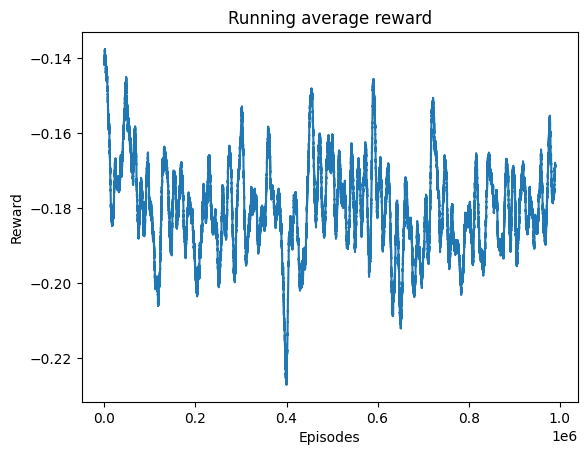

In [6]:
from src.explorations import EpsilonGreedy
from src.utils.general import get_num_states

n_episodes = 1000000
eps = 0.1
decay = 1
alpha = 0.05
gamma = 0.9

env = SimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
agent = SarsaAgent(sarsa_parameters, exploration)

rewards = main_sarsa(env, agent, n_episodes)
plot_training_rewards(rewards)

100%|██████████| 10000000/10000000 [12:57<00:00, 12865.68it/s]


Training took 777.26 seconds


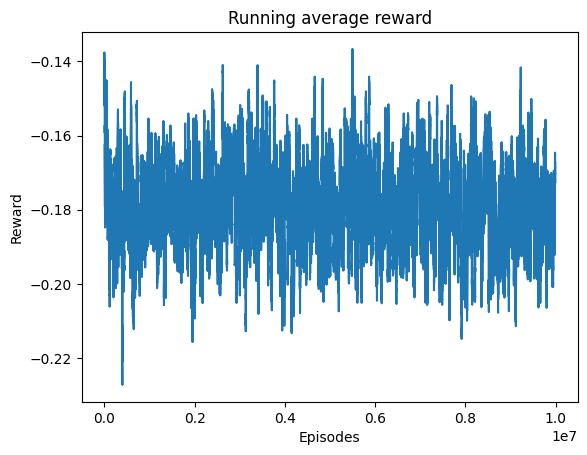

In [7]:
from src.explorations import EpsilonGreedy
from src.utils.general import get_num_states

n_episodes = 10_000_000
eps = 0.1
decay = 1
alpha = 0.05
gamma = 0.9

env = SimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
agent = SarsaAgent(sarsa_parameters, exploration)

rewards = main_sarsa(env, agent, n_episodes)
plot_training_rewards(rewards)

In [8]:
n_test_episodes = 1_000_000

rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.3860
Draw rate: 0.0852


100%|██████████| 1000000/1000000 [01:38<00:00, 10157.34it/s]


Training took 98.45 seconds


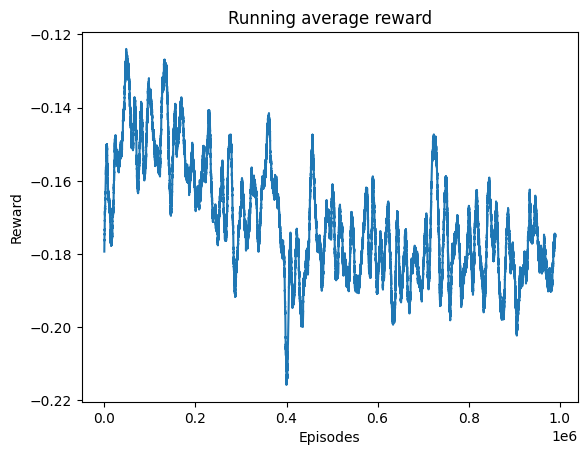

Win rate: 0.3700
Draw rate: 0.0798


In [6]:
from src.explorations import UCB
from src.utils.general import get_num_states

n_episodes = 1_000_000
eps = 0.1
decay = 1
alpha = 0.05
gamma = 0.9

env = SimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
agent = SarsaAgent(sarsa_parameters, exploration)

rewards = main_sarsa(env, agent, n_episodes)
plot_training_rewards(rewards)

n_test_episodes = 1_000_000
env = SimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [9]:
def train_sarsa(n_episodes, eps, decay, alpha, gamma):
    env = SimpleBlackjack(seed=42)
    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    sarsa_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
    agent = SarsaAgent(sarsa_parameters, exploration)

    rewards = main_sarsa(env, agent, n_episodes)
    return rewards, agent

def multi_test(agents, n_test_episodes):
    results = []
    for agent in agents:
        env = SimpleBlackjack(seed=666)
        rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
        rewards = np.array(rewards)
        n_wins = np.sum(rewards == 1)
        n_draws = np.sum(rewards == 0)
        results.append((n_wins / n_test_episodes, n_draws / n_test_episodes))
    return results        

def multi_plot(rewards_list, results, title, factor, values):
    plt.figure(figsize=(30, 8), dpi=80)
    plt.gca().set_xticks([])  # Remove x-axis tick marks
    plt.gca().set_xticklabels([])  # Remove x-axis labels
    plt.gca().spines['bottom'].set_visible(False)  # Hide x-axis line
    plt.gca().spines['top'].set_visible(False)  # Hide x-axis line
    for k, (rewards, result, value) in enumerate(zip(rewards_list, results, values)):
        plt.subplot(1, len(rewards_list), k + 1, sharey=plt.gca())
        running_average = gaussian_smoothing_gpu(rewards)
        plt.plot(running_average)
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title(f"{factor} = {value}, Win Rate: {result[0]:.4f}, Draw Rate: {result[1]:.4f}")
    plt.suptitle(title)
    plt.show()

    plt.figure(figsize=(30, 8), dpi=80)
    plt.plot(values, [result[0] for result in results], label="Win Rate")
    plt.plot(values, [result[1] for result in results], label="Draw Rate")
    plt.xlabel(f"{factor}")
    plt.ylabel("Rate")
    plt.title("Win and Draw Rate")
    plt.legend()
    plt.show()

#### Influence of the epsilon value

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [01:18<00:00, 12813.95it/s]


Training took 78.04 seconds


100%|██████████| 1000000/1000000 [01:16<00:00, 13108.62it/s]


Training took 76.29 seconds


100%|██████████| 1000000/1000000 [01:15<00:00, 13242.67it/s]


Training took 75.51 seconds


100%|██████████| 1000000/1000000 [01:15<00:00, 13292.00it/s]


Training took 75.23 seconds


100%|██████████| 1000000/1000000 [01:11<00:00, 13915.24it/s]


Training took 71.86 seconds


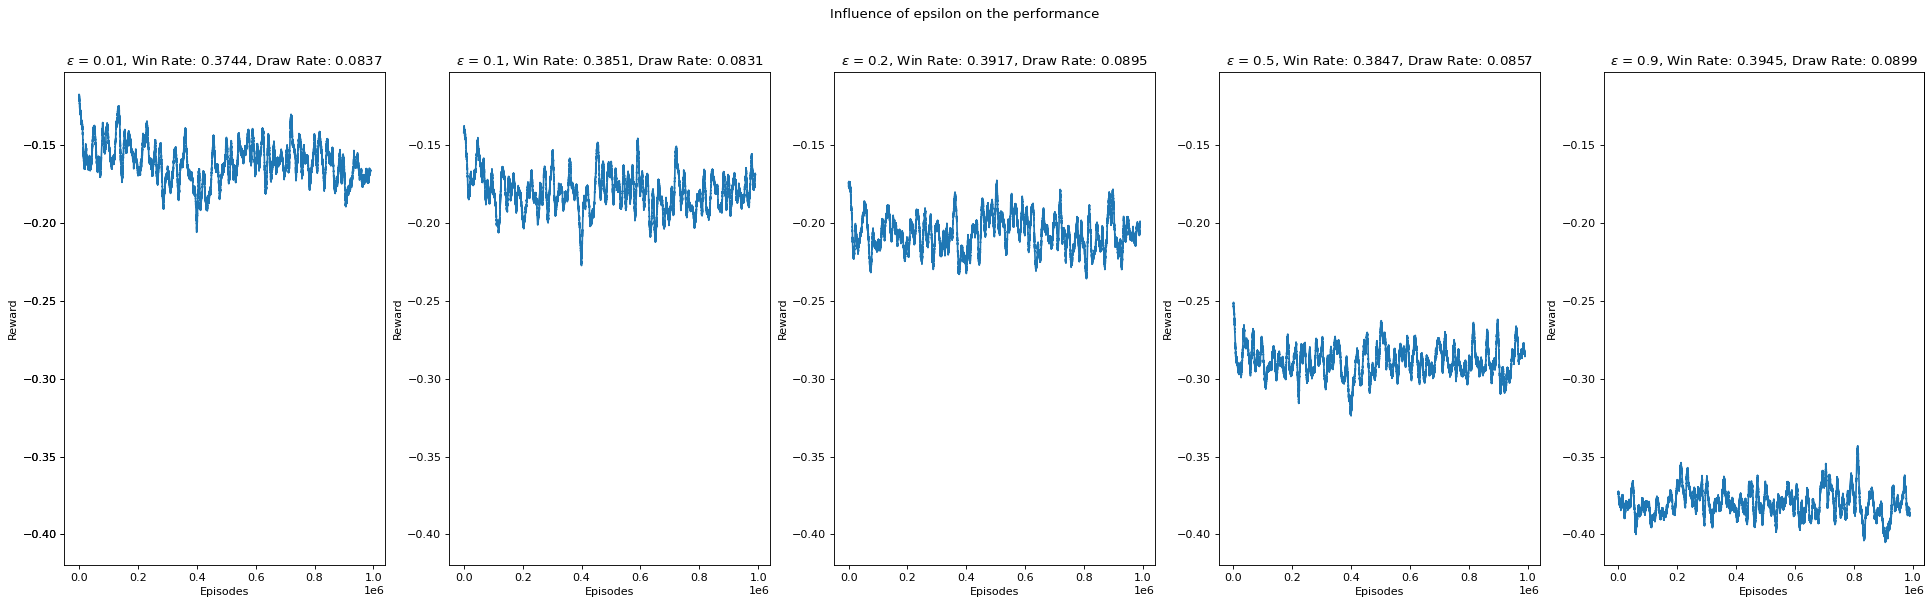

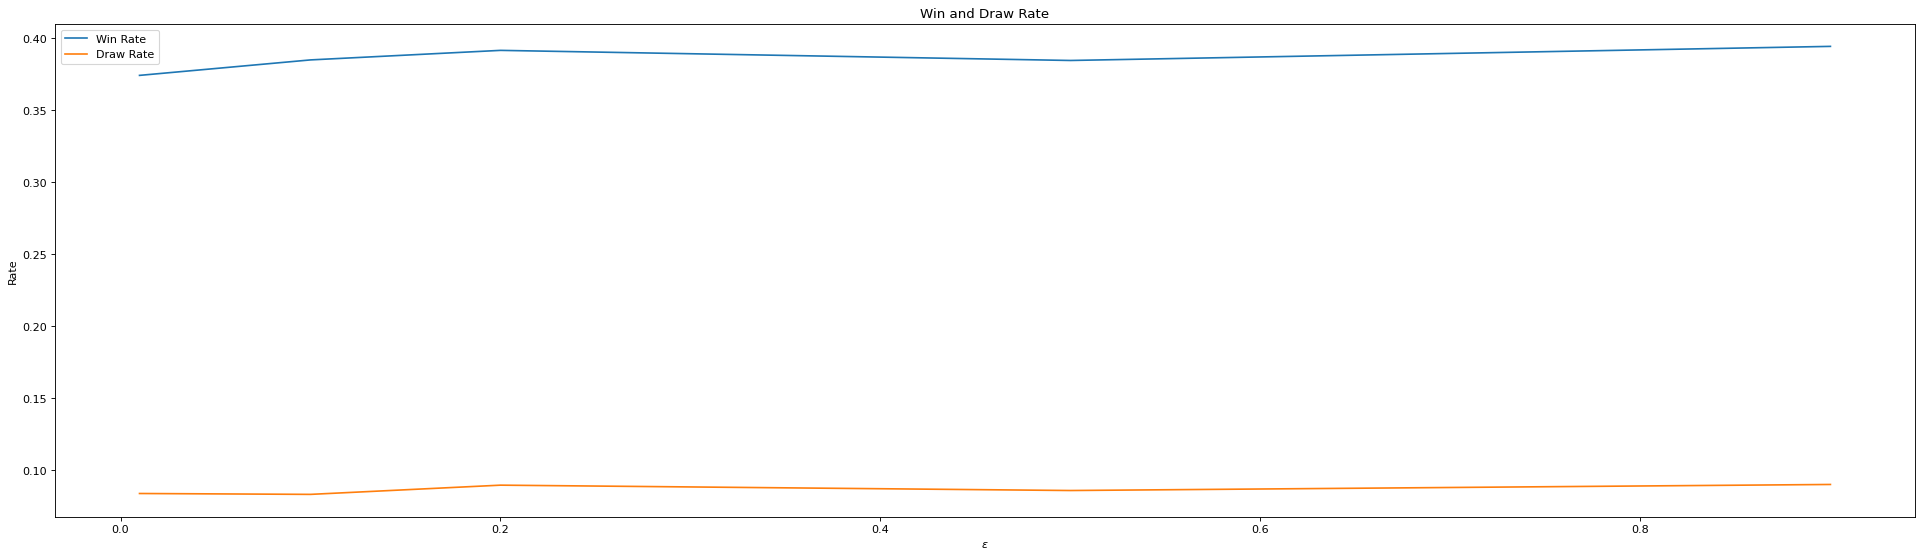

In [10]:
n_episodes = 1_000_000
n_test_episodes = 1_000_000
decay = 1
alpha = 0.05
gamma = 0.9

epsilons = [0.01, 0.1, 0.2, 0.5, 0.9]
agents = []
rewards_list = []

for eps in epsilons:
    rewards, agent = train_sarsa(n_episodes, eps, decay, alpha, gamma)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of epsilon on the performance", r"$\epsilon$", epsilons)

#### Influence of the learning rate

100%|██████████| 1000000/1000000 [01:12<00:00, 13809.28it/s]


Training took 72.42 seconds


100%|██████████| 1000000/1000000 [01:12<00:00, 13754.51it/s]


Training took 72.70 seconds


100%|██████████| 1000000/1000000 [01:12<00:00, 13703.39it/s]


Training took 72.98 seconds


100%|██████████| 1000000/1000000 [01:13<00:00, 13686.07it/s]


Training took 73.07 seconds


100%|██████████| 1000000/1000000 [01:12<00:00, 13751.22it/s]


Training took 72.72 seconds


100%|██████████| 1000000/1000000 [01:12<00:00, 13753.52it/s]


Training took 72.71 seconds


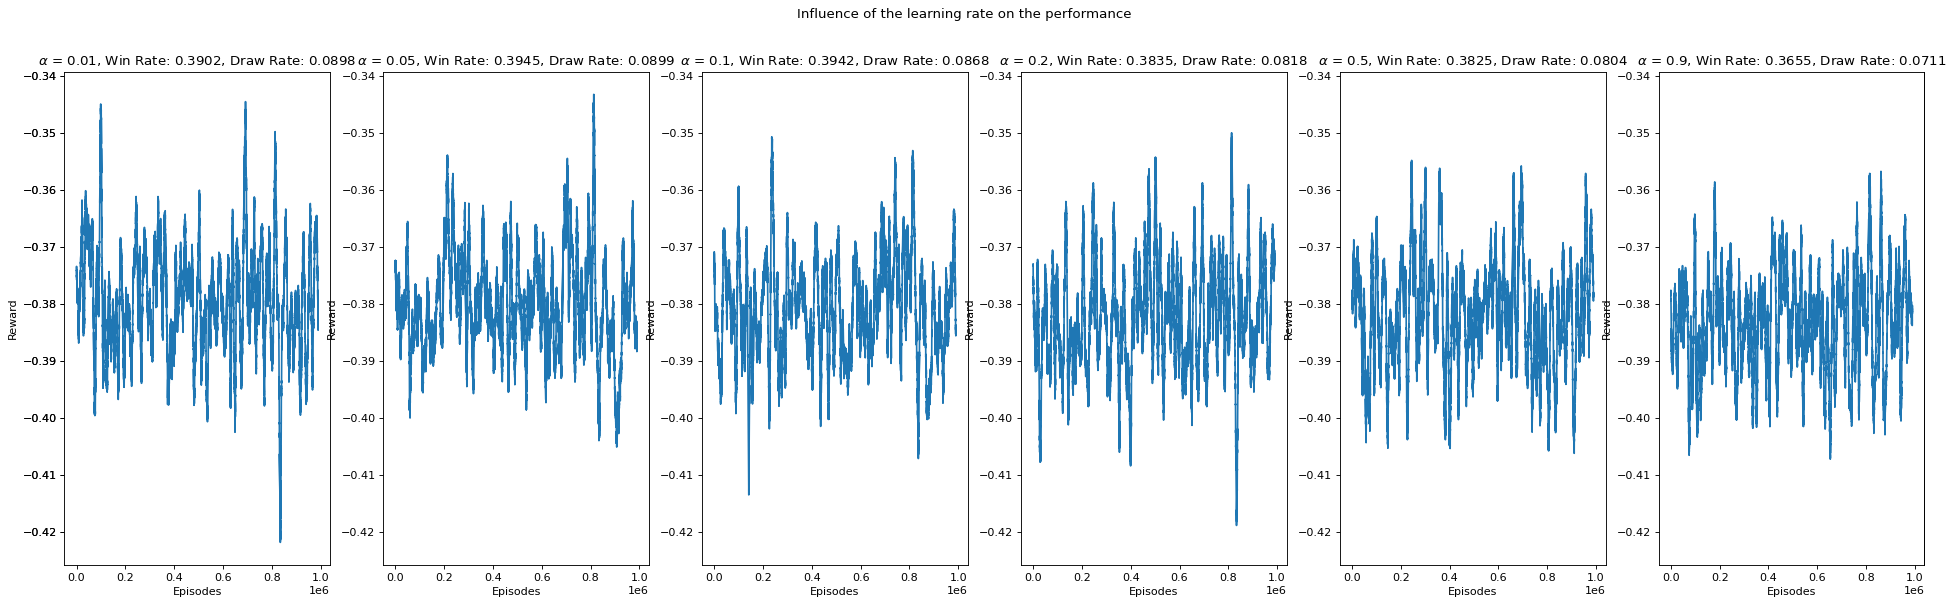

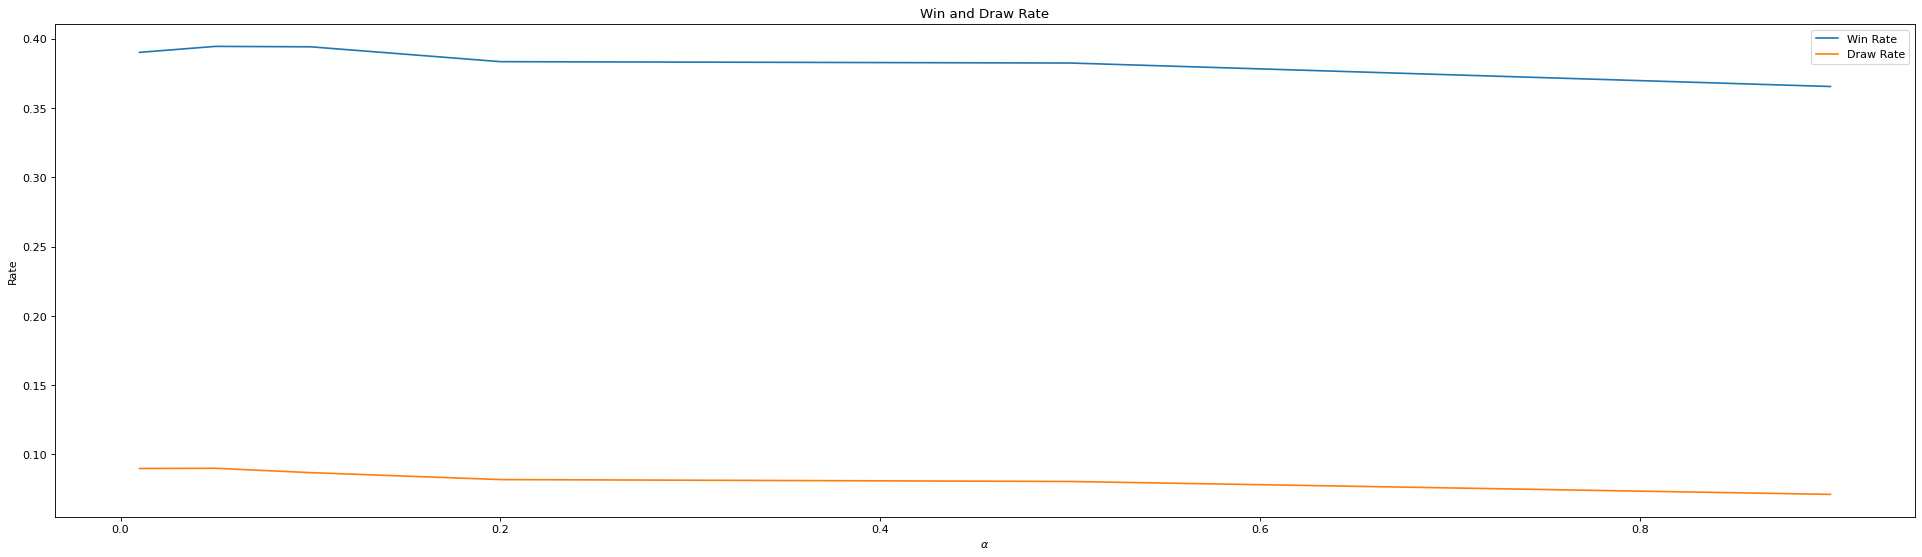

In [11]:
n_episodes = 1_000_000
n_test_episodes = 1_000_000
decay = 1
epsilon = 0.1
gamma = 0.9

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
agents = []
rewards_list = []

for alpha in alphas:
    rewards, agent = train_sarsa(n_episodes, eps, decay, alpha, gamma)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of the learning rate on the performance", r"$\alpha$", alphas)

### Q learning

In [7]:
from src.utils.data_struct import QlearningParameters
from src.agents import QlearningAgent

def main_qlearning(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)
            
            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)
        rewards[k] = reward

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

#### Epssilon greedy

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [01:17<00:00, 12838.18it/s]


Training took 77.89 seconds


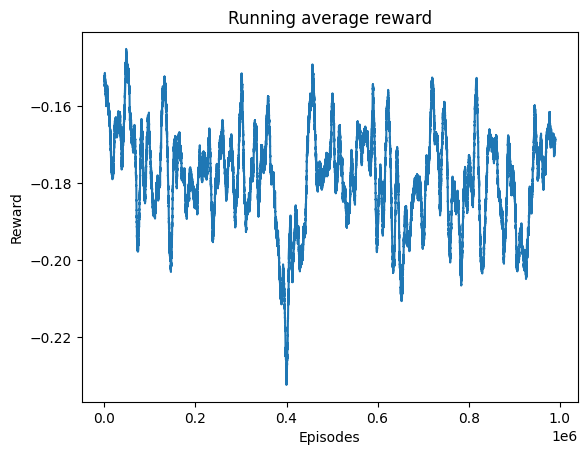

In [13]:
from src.explorations import EpsilonGreedy
from src.utils.general import get_num_states

n_episodes = 1_000_000
eps = 0.1
decay = 1
alpha = 0.05
gamma = 0.9

env = SimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
sarsa_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
agent = QlearningAgent(sarsa_parameters, exploration)

rewards = main_qlearning(env, agent, n_episodes)
plot_training_rewards(rewards)

100%|██████████| 1000000/1000000 [01:32<00:00, 10810.23it/s]


Training took 92.50 seconds


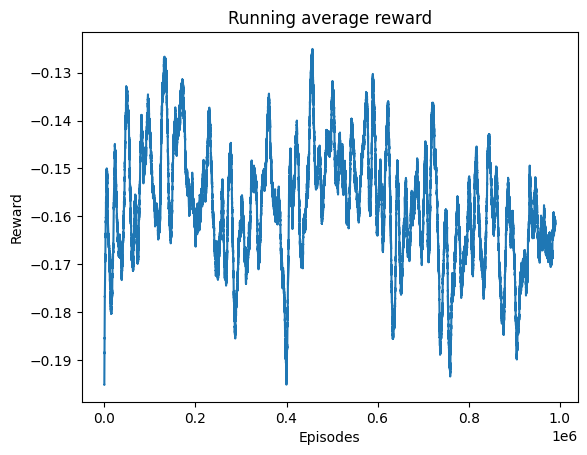

Win rate: 0.3773
Draw rate: 0.0819


In [8]:
from src.explorations import UCB
from src.utils.general import get_num_states

n_episodes = 1_000_000
alpha = 0.05
gamma = 0.9

env = SimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_params = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
agent = QlearningAgent(qlearning_params, exploration)

rewards = main_qlearning(env, agent, n_episodes)
plot_training_rewards(rewards)

n_test_episodes = 1_000_000
env = SimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [14]:
def train_qlearning(n_episodes, eps, decay, alpha, gamma):
    env = SimpleBlackjack(seed=42)
    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    sarsa_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, alpha=alpha, gamma=gamma)
    agent = QlearningAgent(sarsa_parameters, exploration)

    rewards = main_qlearning(env, agent, n_episodes)
    return rewards, agent

##### Influence of the epsilon value

100%|██████████| 1000000/1000000 [01:19<00:00, 12632.72it/s]


Training took 79.16 seconds


100%|██████████| 1000000/1000000 [01:18<00:00, 12791.89it/s]


Training took 78.18 seconds


100%|██████████| 1000000/1000000 [01:17<00:00, 12959.77it/s]


Training took 77.16 seconds


100%|██████████| 1000000/1000000 [01:15<00:00, 13175.81it/s]


Training took 75.90 seconds


100%|██████████| 1000000/1000000 [01:14<00:00, 13462.35it/s]


Training took 74.28 seconds


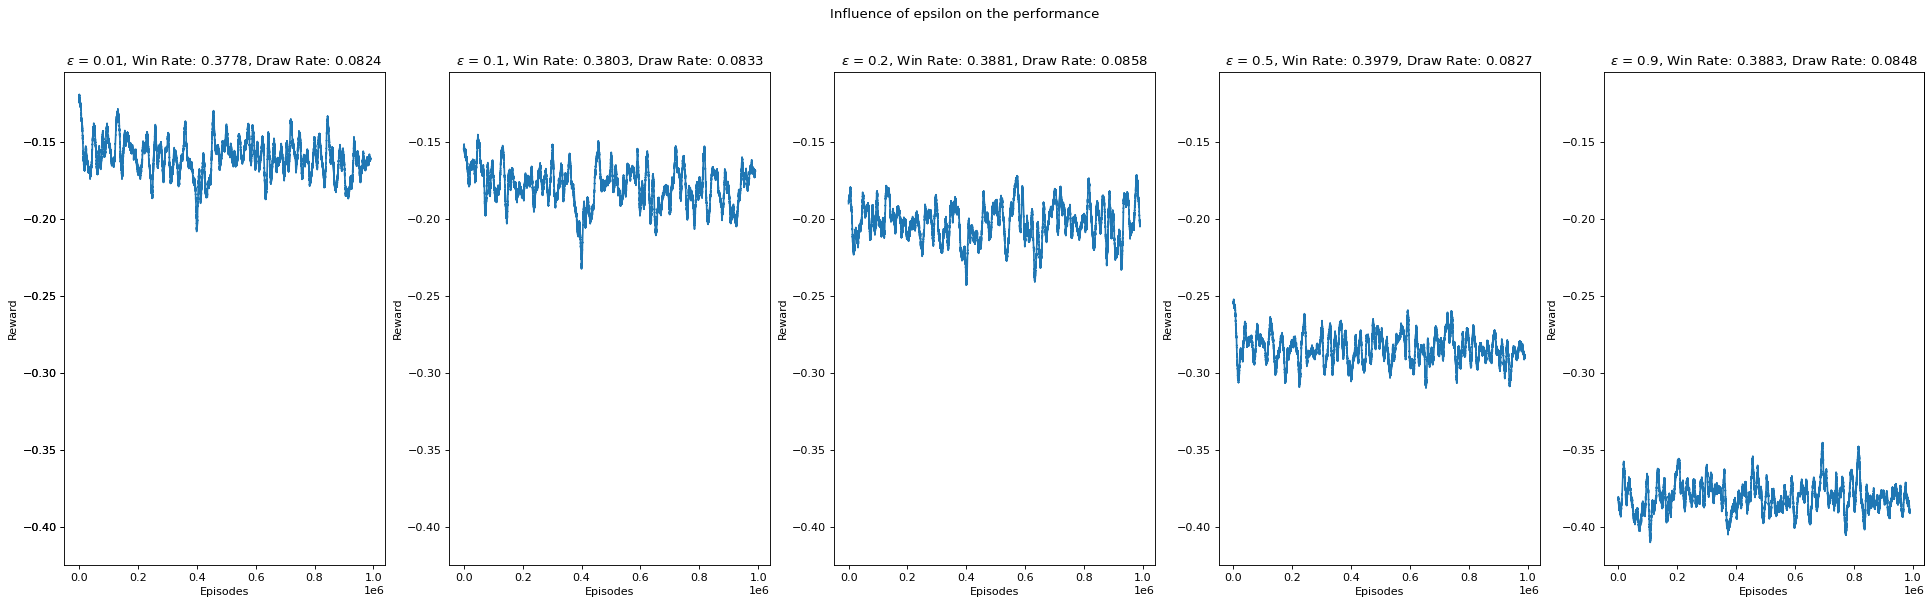

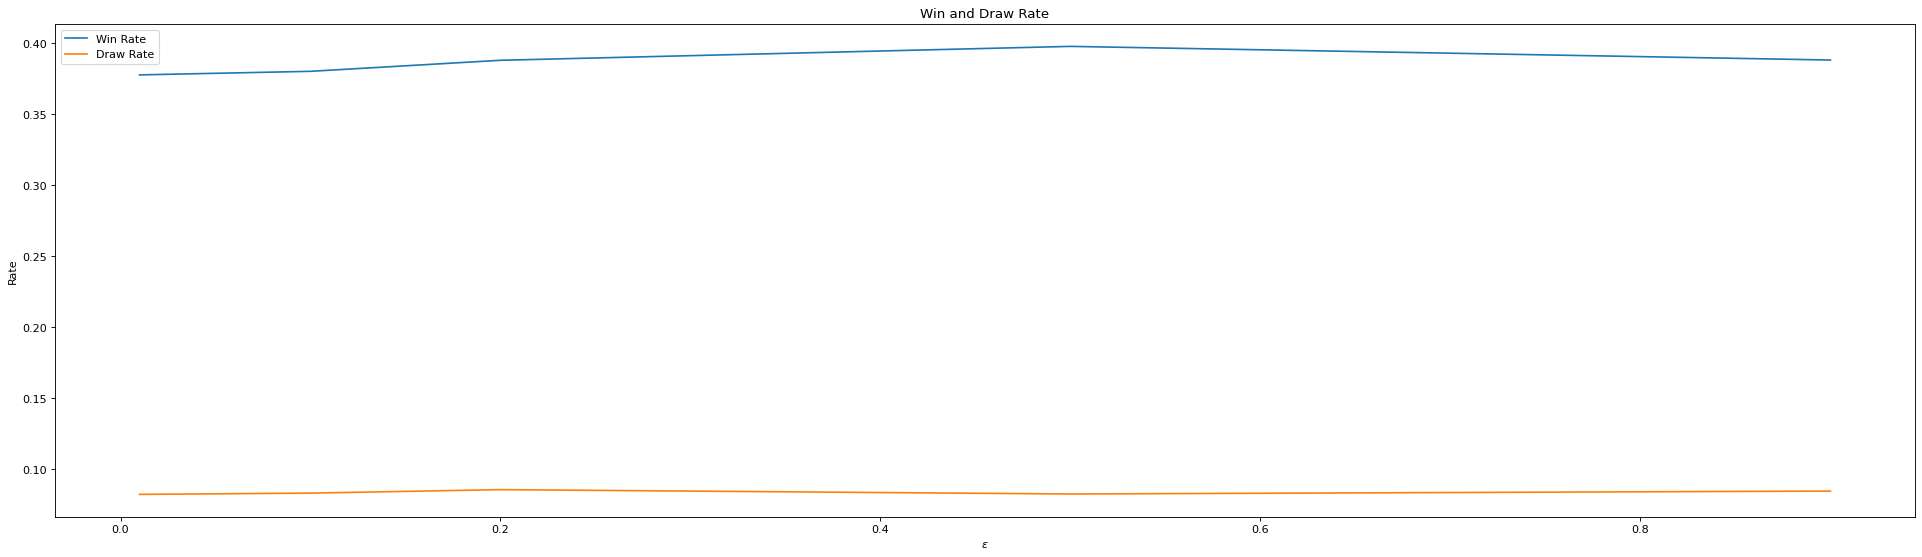

In [15]:
n_episodes = 1_000_000
n_test_episodes = 1_000_000
decay = 1
alpha = 0.05
gamma = 0.9

epsilons = [0.01, 0.1, 0.2, 0.5, 0.9]
agents = []
rewards_list = []

for eps in epsilons:
    rewards, agent = train_qlearning(n_episodes, eps, decay, alpha, gamma)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of epsilon on the performance", r"$\epsilon$", epsilons)

##### Influence of the learning rate

100%|██████████| 1000000/1000000 [01:16<00:00, 13052.14it/s]


Training took 76.62 seconds


100%|██████████| 1000000/1000000 [01:16<00:00, 13077.48it/s]


Training took 76.47 seconds


100%|██████████| 1000000/1000000 [01:16<00:00, 13097.76it/s]


Training took 76.35 seconds


100%|██████████| 1000000/1000000 [01:16<00:00, 13132.37it/s]


Training took 76.15 seconds


100%|██████████| 1000000/1000000 [01:15<00:00, 13250.42it/s]


Training took 75.47 seconds


100%|██████████| 1000000/1000000 [01:15<00:00, 13289.48it/s]


Training took 75.25 seconds


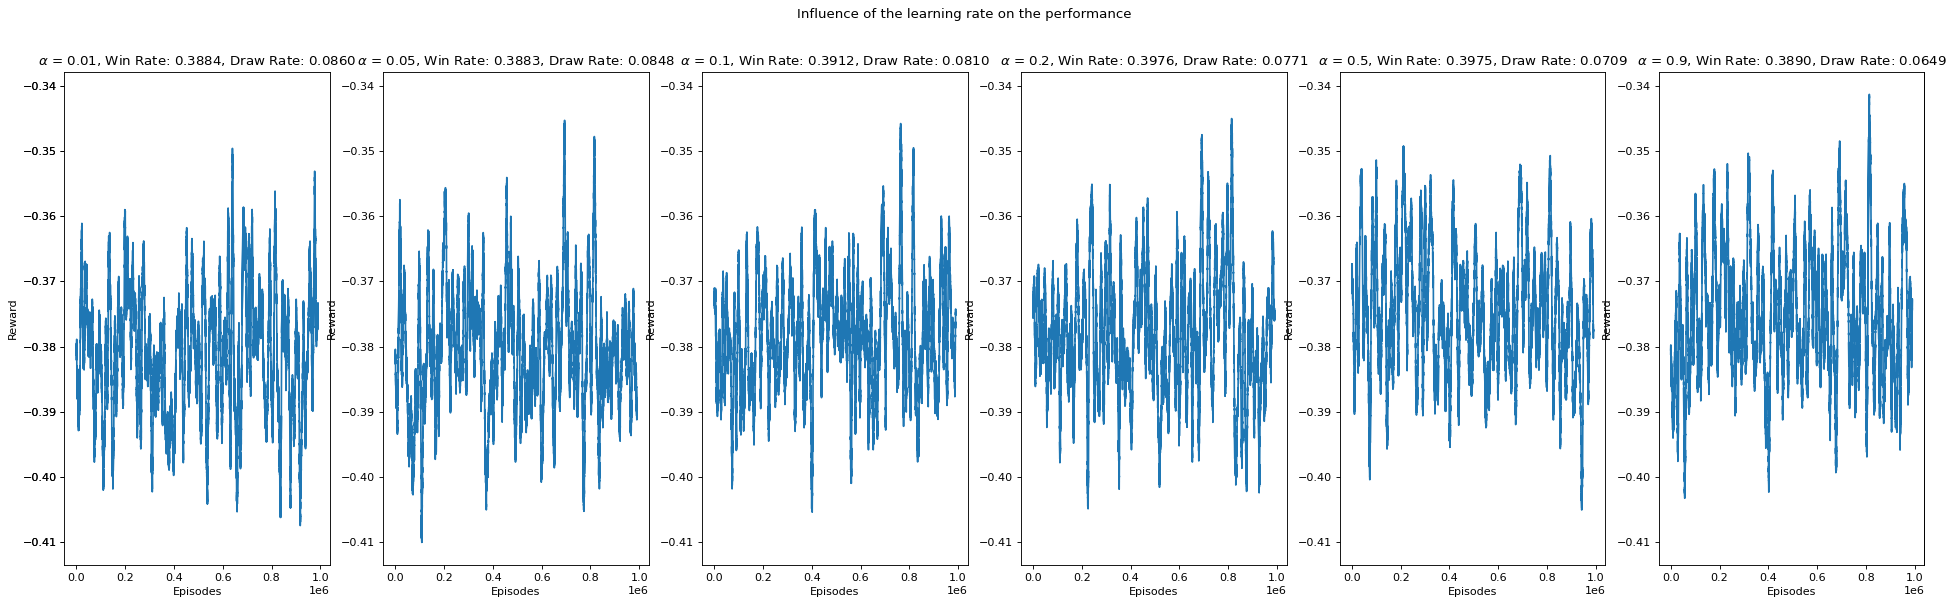

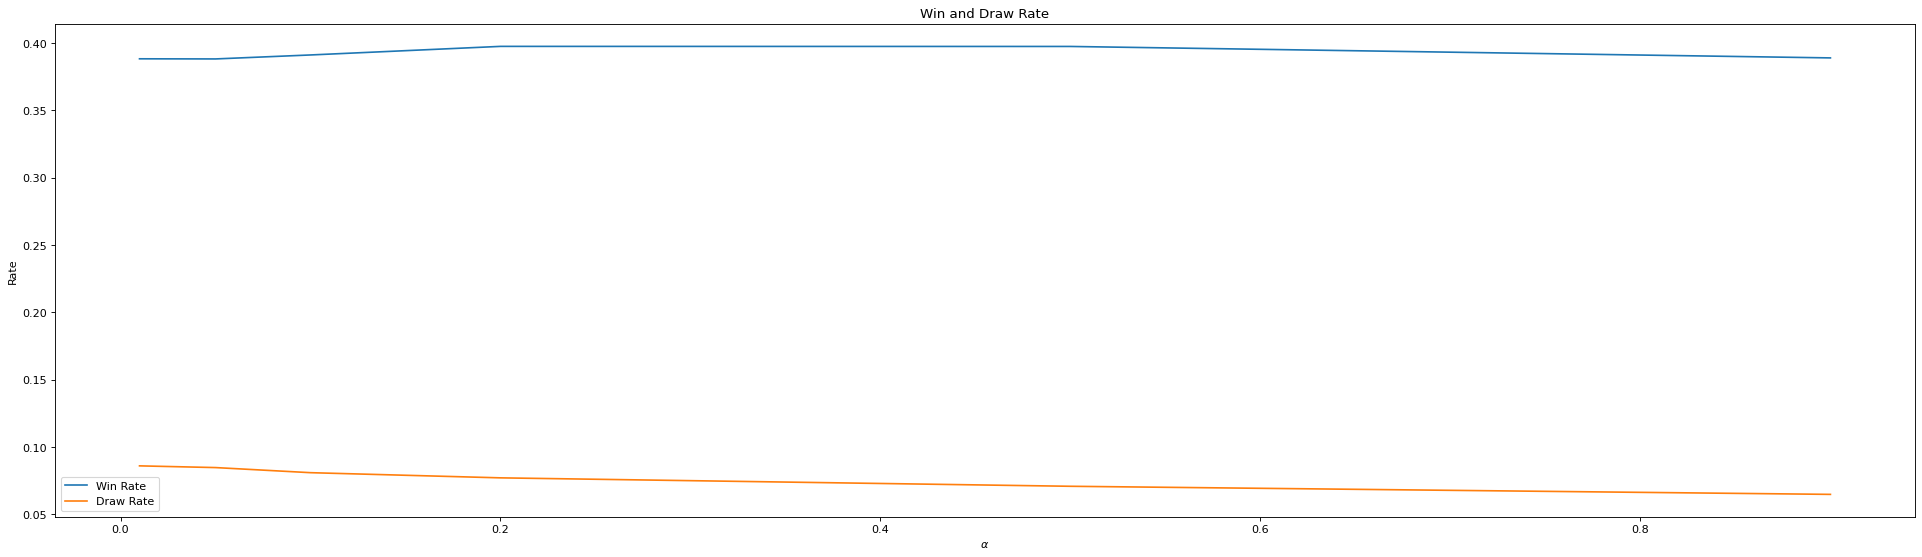

In [16]:
n_episodes = 1_000_000
n_test_episodes = 1_000_000
decay = 1
epsilon = 0.1
gamma = 0.9

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]
agents = []
rewards_list = []

for alpha in alphas:
    rewards, agent = train_qlearning(n_episodes, eps, decay, alpha, gamma)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of the learning rate on the performance", r"$\alpha$", alphas)

##### Influence of the decay rate

100%|██████████| 1000000/1000000 [01:15<00:00, 13185.24it/s]


Training took 75.84 seconds


100%|██████████| 1000000/1000000 [01:19<00:00, 12587.75it/s]


Training took 79.44 seconds


100%|██████████| 1000000/1000000 [01:19<00:00, 12617.17it/s]


Training took 79.26 seconds


100%|██████████| 1000000/1000000 [01:18<00:00, 12662.51it/s]


Training took 78.97 seconds


100%|██████████| 1000000/1000000 [01:19<00:00, 12531.81it/s]


Training took 79.80 seconds


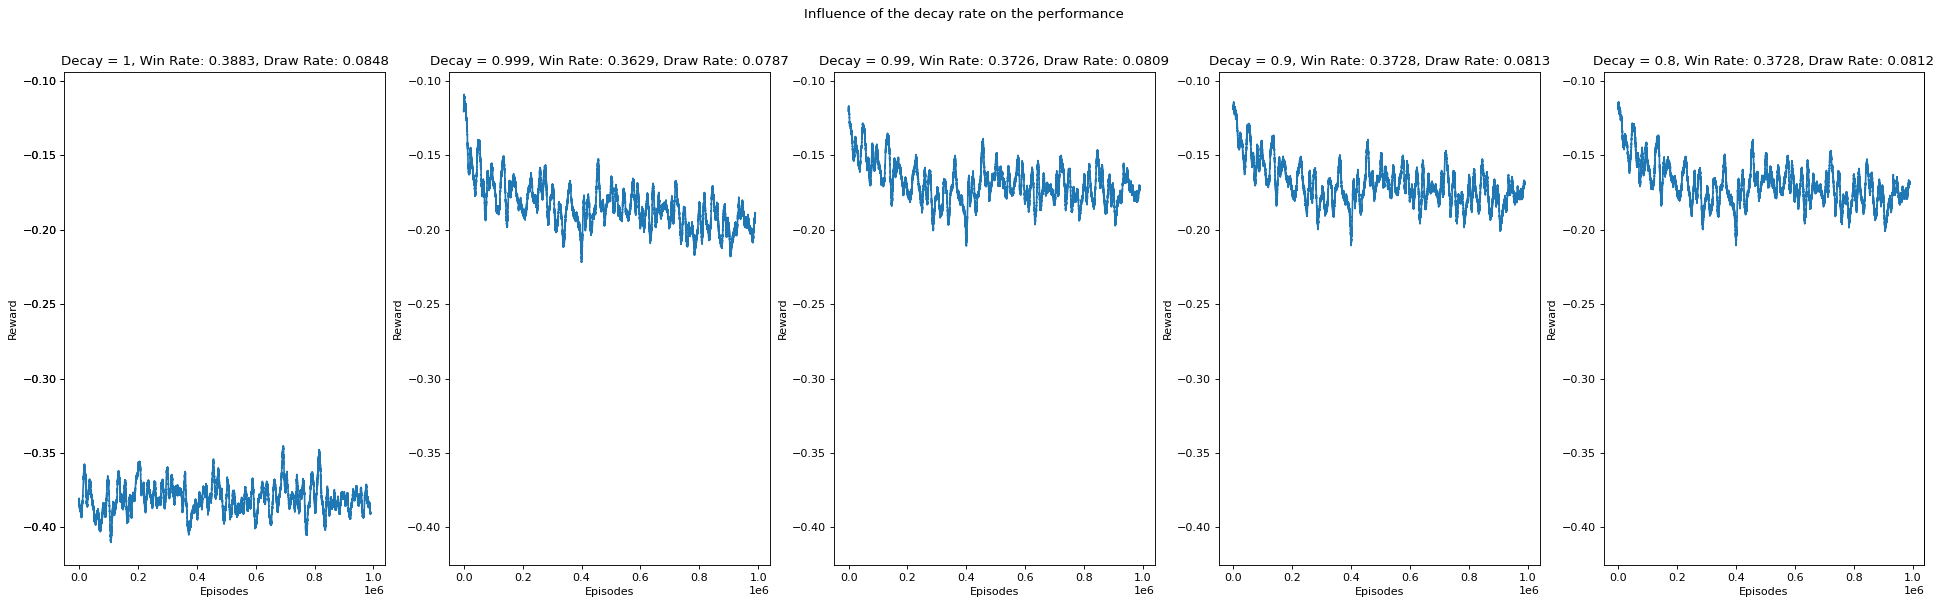

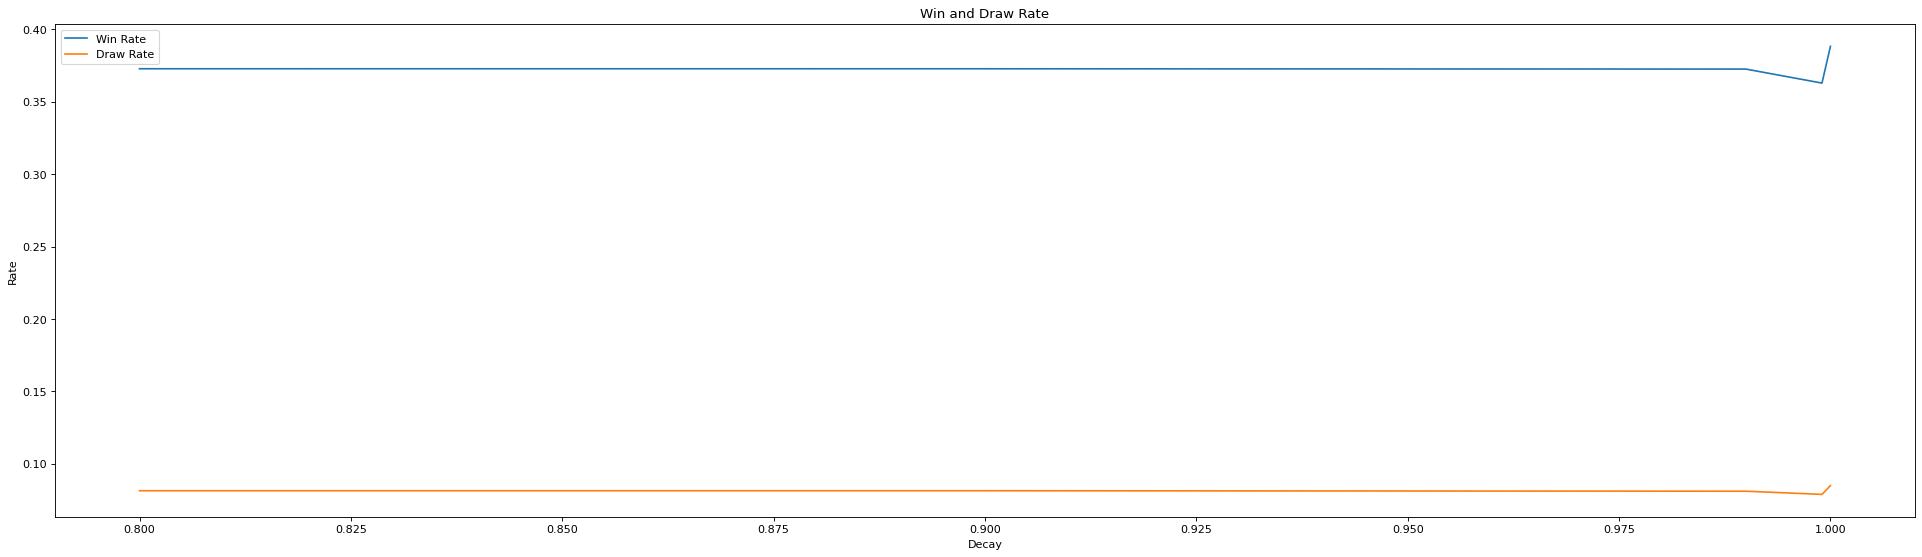

In [17]:
n_episodes = 1_000_000
n_test_episodes = 1_000_000
epsilon = 0.1
gamma = 0.9
alpha = 0.05

decays = [1, 0.999, 0.99, 0.9, 0.8]
agents = []
rewards_list = []

for decay in decays:
    rewards, agent = train_qlearning(n_episodes, eps, decay, alpha, gamma)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of the decay rate on the performance", "Decay", decays)

### Deep Q learning

In [18]:
from src.agents import DQN
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = torch.Tensor(state).float()
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = torch.Tensor(next_state).float()
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)
        rewards[k] = reward

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

def play_episode(env: gym.Env, agent: DQN) -> float:
    state = env.reset()
    state = torch.Tensor(state).float()
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        next_state = torch.Tensor(next_state).float()
        state = next_state
    return reward

100%|██████████| 100000/100000 [02:05<00:00, 794.18it/s]


Training took 125.92 seconds


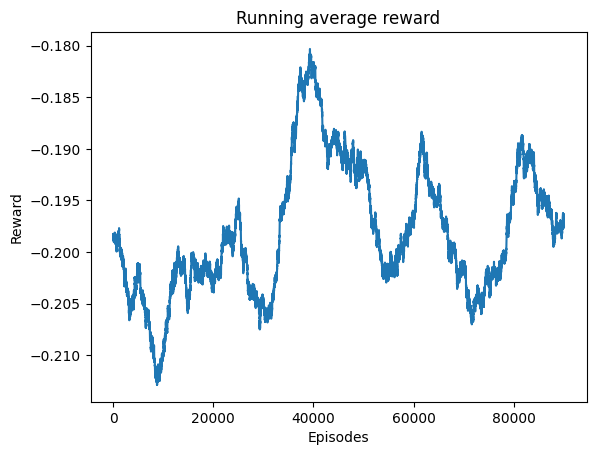

In [19]:
from src.explorations import EpsilonGreedy
from src.networks import MLP
from src.utils.data_struct import DQNParameters
from src.utils.buffer import ReplayBuffer

device = torch.device("cpu")


n_episodes = 100_000
eps = 0.1
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4

env = SimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
dqn_parameters = DQNParameters(batch_size=batch_size, gamma=gamma, freq_target_update=freq_target_update, device=device)

network = MLP(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
target_network = MLP(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
target_network.load_state_dict(network.state_dict())

network = network.to(device)
target_network = target_network.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(network.parameters(), lr=lr, weight_decay=weight_decay)
buffer = ReplayBuffer(capacity=buffer_capacity)

agent = DQN(q_network=network, target_network=target_network, params=dqn_parameters, exploration=exploration, criterion=criterion, optimizer=optimizer, replay_buffer=buffer)

rewards = main_dqn(env, agent, n_episodes)
plot_training_rewards(rewards)

In [20]:
n_test_episodes = 1_000_000

rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4059
Draw rate: 0.0742


In [21]:
def train_dqn(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay):
    env = SimpleBlackjack(seed=42)
    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    dqn_parameters = DQNParameters(batch_size=batch_size, gamma=gamma, freq_target_update=freq_target_update, device=device)

    network = MLP(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network = MLP(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network.load_state_dict(network.state_dict())

    network = network.to(device)
    target_network = target_network.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(network.parameters(), lr=lr, weight_decay=weight_decay)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    agent = DQN(q_network=network, target_network=target_network, params=dqn_parameters, exploration=exploration, criterion=criterion, optimizer=optimizer, replay_buffer=buffer)

    rewards = main_dqn(env, agent, n_episodes)
    return rewards, agent

100%|██████████| 100000/100000 [01:43<00:00, 963.91it/s]


Training took 103.75 seconds


100%|██████████| 500000/500000 [12:10<00:00, 684.19it/s]


Training took 730.79 seconds


100%|██████████| 1000000/1000000 [23:25<00:00, 711.73it/s]


Training took 1405.02 seconds


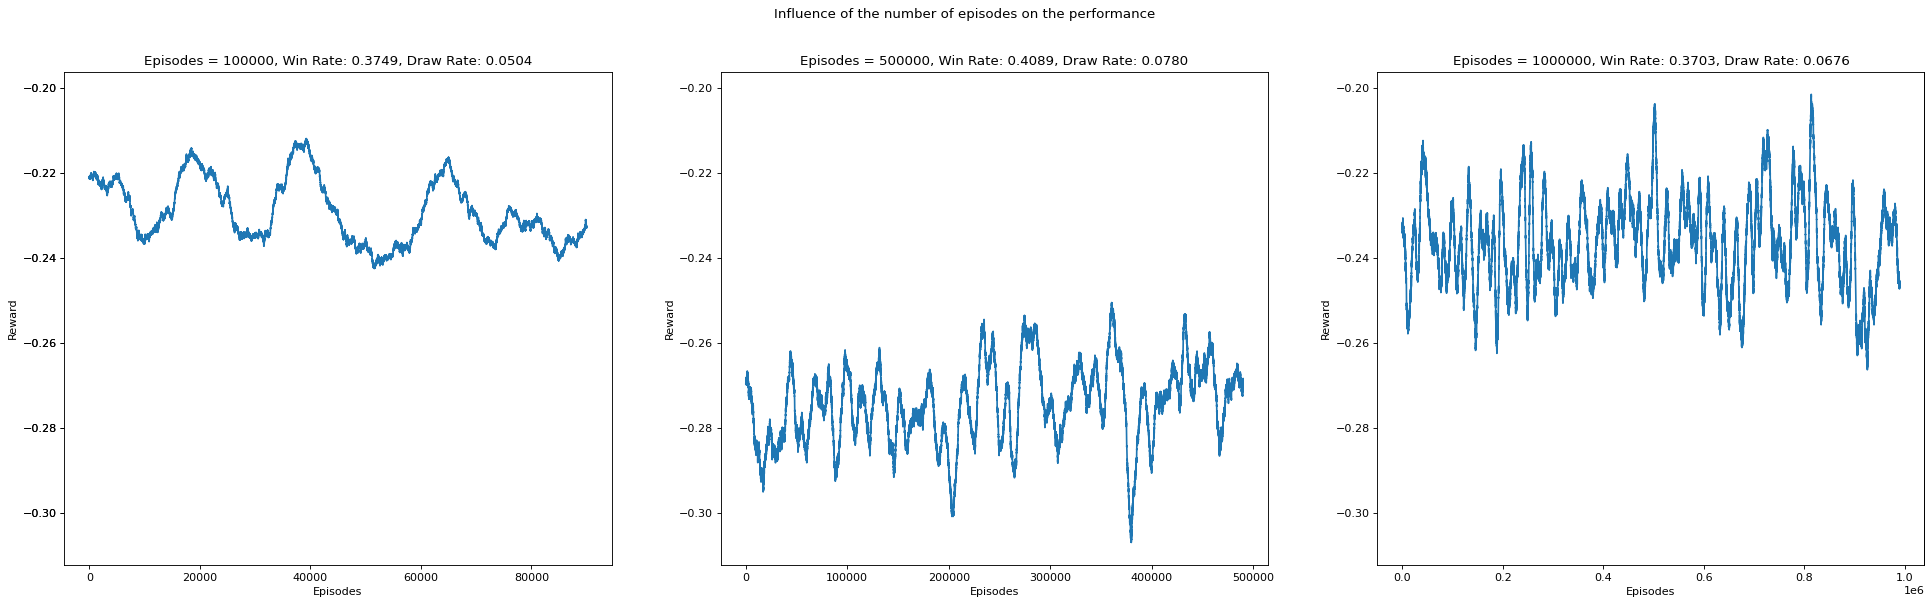

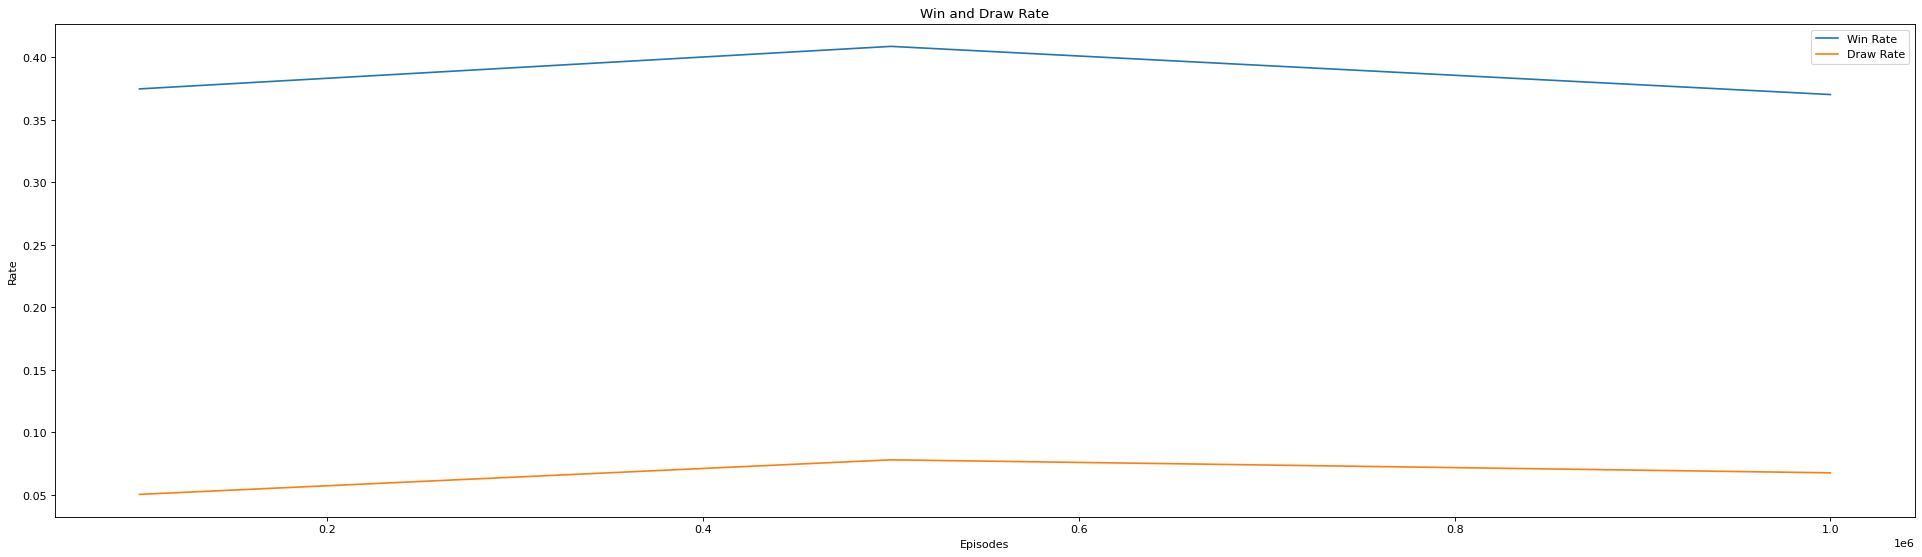

In [22]:
eps = 0.1
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4

episodes = [100_000, 500_000, 1_000_000]
agents = []
rewards_list = []

for n_episodes in episodes:
    rewards, agent = train_dqn(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of the number of episodes on the performance", "Episodes", episodes)

100%|██████████| 250000/250000 [05:43<00:00, 727.40it/s]


Training took 343.69 seconds


100%|██████████| 250000/250000 [05:04<00:00, 820.31it/s]


Training took 304.77 seconds


100%|██████████| 250000/250000 [05:19<00:00, 783.66it/s]


Training took 319.01 seconds


100%|██████████| 250000/250000 [05:30<00:00, 756.25it/s]


Training took 330.58 seconds


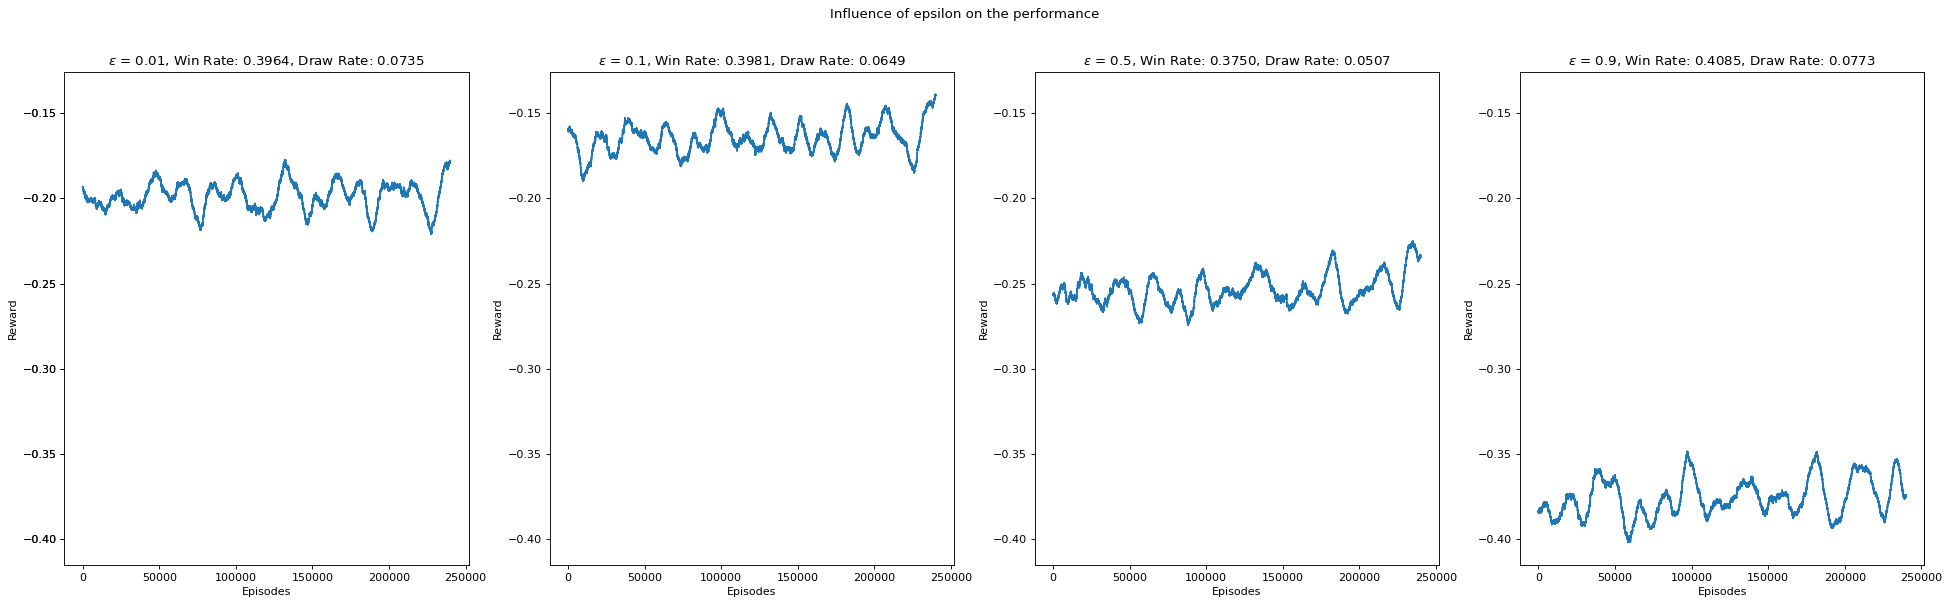

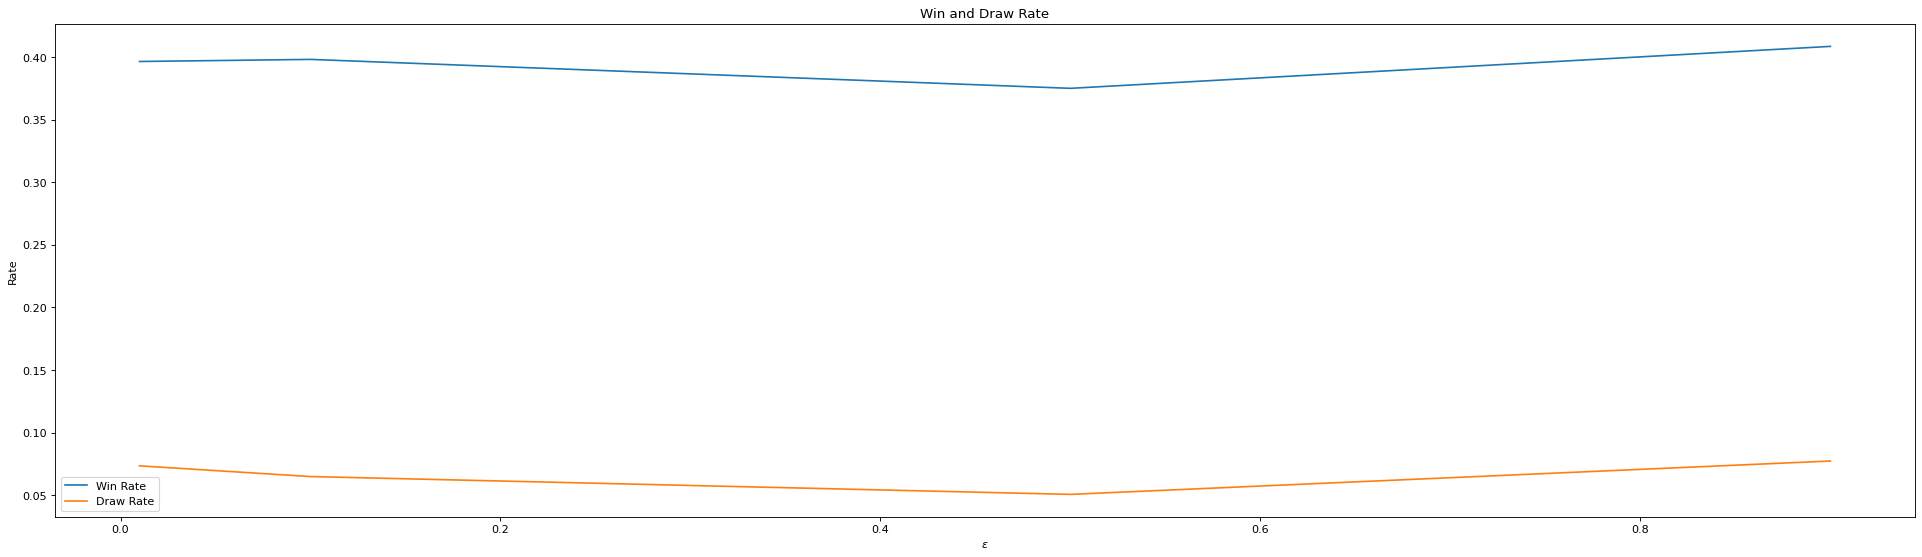

In [24]:
n_episodes = 250_000
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4

epsilons = [0.01, 0.1, 0.5, 0.9]
agents = []
rewards_list = []

for eps in epsilons:
    rewards, agent = train_dqn(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay)
    agents.append(agent)
    rewards_list.append(rewards)

results = multi_test(agents, n_test_episodes)
multi_plot(rewards_list, results, "Influence of epsilon on the performance", r"$\epsilon$", epsilons)